# Prediction of Fat Levels in Canadian Cheese

##### <b>Author :</b> Muntakim Rahman &nbsp; <b>UBC Student Number :</b> 71065221

# Introduction

This **Jupyter Notebook** will be implementing *Machine Learning (ML)* models to predict the fat levels in *Canadian* cheeses. 

## Intended Outcome

We can utilize a rich understanding of the factors which yield high fat levels to reduce the risk of mass manufacturing an unsuccessful product. 

We are already confident that the *Total Addressable Market (TAM)* is particularly concerned with fat level in cheeses (*as per a previous study on consumer tastes*). We would like to manufacture `lower fat` cheese products and this will act as our positive label.

## What is Machine Learning?

*Machine Learning* is defined by *IBM* as *the use of statistical methods, algorithms that are trained to make classifications or predictions, and to uncover key insights in data mining projects. These insights subsequently drive decision making within applications and businesses, ideally impacting key growth metrics.* 

## Cheese Classification

We will be identifying different features within our dataset in order to classify our different cheeses as either `lower fat` or `higher fat`.  

### Estimators

We will be creating, training, and evaluating a set of *ML* models (i.e. estimators), which will be compared to a baseline model, in our case a *Dummy Classifier*. 

This will involve : 

<ul>
    <li>Tactful preprocessing of our data with imputation, scaling, feature transformations</li>
    <li>Training the classifier models with an appropriately split and balanced dataset.</li>
    <li>Picking the estimator with the best validation score and finetuning the hyperparameters.</li>
    <li>Assessing model performance with performance metrics.</li>
</ul>

### Further Exploration - Will Be Performed Based on Data Availability

These are questions I want to explore given data availability in addition to the above analysis.

## Dataset Description

This dataset provides an overview of the different types of Canadian cheeses. The original data was found on the *Government of Canada's Open Government Portal* but has unfortunately been taken down. What we have here is a wrangled and partially cleaned, modified version of the original dataset.

# Exploratory Data Analysis

In [48]:
# Lets import all the required libraries needed for this analysis
import pandas as pd

import altair as alt
import graphviz
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import altair as alt
import seaborn as sns

import datetime as dt

from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale
)
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.svm import SVC, SVR
from sklearn import set_config

alt.data_transformers.disable_max_rows()

from cheese_functions import *

In [49]:
directory_df = pd.read_csv("data/canadianCheeseDirectory.csv")
display(directory_df.head())

,CheeseId,CheeseNameEn,CheeseNameFr,ManufacturerNameEn,ManufacturerNameFr,ManufacturerProvCode,ManufacturingTypeEn,ManufacturingTypeFr,WebSiteEn,WebSiteFr,...,Organic,CategoryTypeEn,CategoryTypeFr,MilkTypeEn,MilkTypeFr,MilkTreatmentTypeEn,MilkTreatmentTypeFr,RindTypeEn,RindTypeFr,LastUpdateDate
0,228,NaN,Sieur de Duplessis (Le),NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,0,Firm Cheese,Pâte ferme,Ewe,Brebis,Raw Milk,Lait cru,Washed Rind,Croûte lavée,2016-02-03
1,242,NaN,Tomme Le Champ Doré,NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,0,Semi-soft Cheese,Pâte demi-ferme,Cow,Vache,Raw Milk,Lait cru,Washed Rind,Croûte lavée,2016-02-03
2,301,Provolone Sette Fette (Tre-Stelle),Provolone Sette Fette (Tre-Stelle),Tre Stelle (Arla Foods),NaN,ON,Industrial,Industrielle,http://www.trestelle.ca/english/,http://www.trestelle.ca/francais/,...,0,Firm Cheese,Pâte ferme,Cow,Vache,Pasteurized,Pasteurisé,NaN,NaN,2016-02-03
3,303,NaN,Geai Bleu (Le),NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,0,Veined Cheeses,Pâte persillée,Cow,Vache,Raw Milk,Lait cru,NaN,NaN,2016-02-03
4,319,NaN,Gamin (Le),NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,1,Semi-soft Cheese,Pâte demi-ferme,Cow,Vache,Raw Milk,Lait cru,Washed Rind,Croûte lavée,2016-02-03


In [50]:
data_df = pd.read_csv("data/cheese_data.csv")
display(data_df.head())

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


## Golden Rule of Machine Learning

Lets start by separating our training and test datasets. We don't want the test data to influence our model **in any way**. This must act as completely unseen data in the training process.

Lets work with a *80%* training and *20%* test set split.

In [51]:
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 77)

In [52]:
X_train, y_train = train_df.drop(columns = ['FatLevel']), train_df['FatLevel']
X_test, y_test = test_df.drop(columns = ['FatLevel']), test_df['FatLevel']

## Data Exploration

Lets look get an understanding of the data sparsity (i.e. *NULL* values).

In [53]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 110 to 727
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       823 non-null    float64
 4   FlavourEn             649 non-null    object 
 5   CharacteristicsEn     514 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        814 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   779 non-null    object 
 10  RindTypeEn            583 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


None

### Observe Data Sparsity

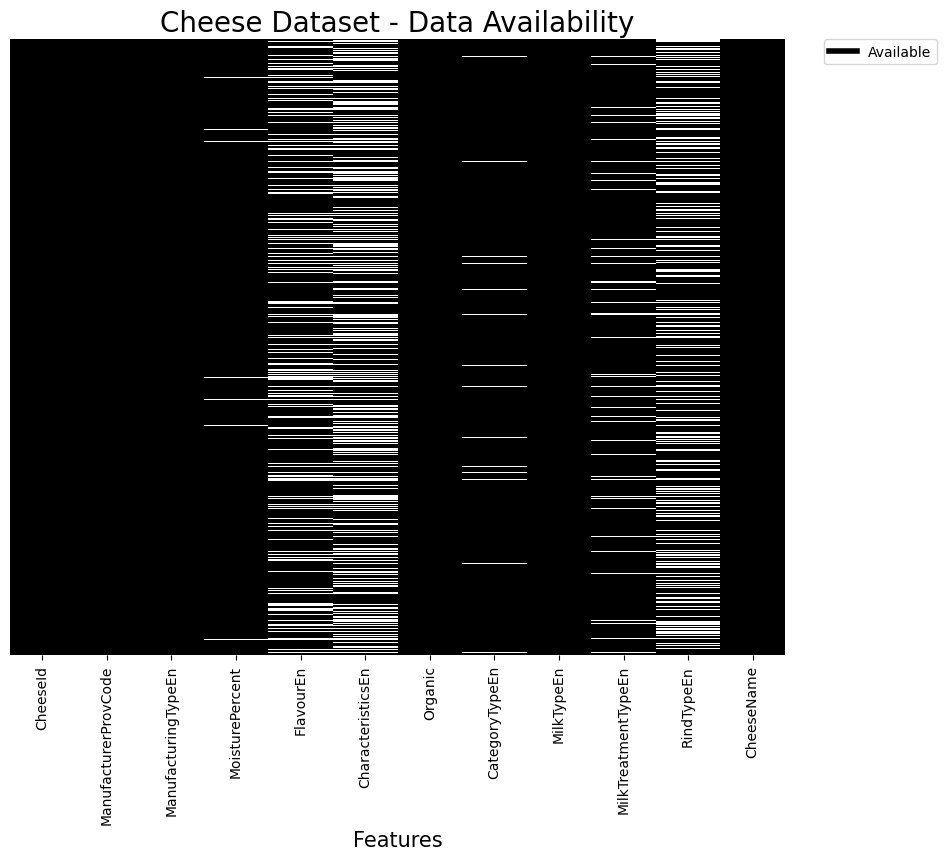

In [54]:
# Look at Data Sparsity in our Training Data.
plt.figure(figsize=(10, 8))

custom_lines = [Line2D([0], [0], color="black", lw=4)]

sparsity_plot = sns.heatmap(
    X_train.notnull(), cmap="binary", cbar=False, yticklabels=False
)

sparsity_plot.set_xlabel("Features", fontsize=15)

sparsity_plot.set_title("Cheese Dataset - Data Availability", fontsize=20)

plt.legend(
    custom_lines,
    ["Available"],
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0,
)

plt.show()

### Observe Features

Lets start by observing the numeric and/or binary features in the dataset.

### Observe Outputs

Lets plot a bar chart showing the quantity of each `FatLevel` in the training data.

In [55]:
fat_prop = alt.Chart(train_df).mark_bar().encode(
    x = alt.X('count()', title = 'Quantity'),
    y = alt.Y('FatLevel:N', title = 'Fat Level'),
    color = alt.Color(
        'FatLevel:N', scale = alt.Scale(
            domain = ['lower fat', 'higher fat'], 
            range= ['teal', 'crimson']
        ), legend = alt.Legend(title = 'Fat Level')
    )
).properties(
    width = 500, height = 300,
    title = 'Fat Level Proportion'
).configure_axis(labelFontSize = 12, titleFontSize = 15).configure_title(fontSize = 20)

display(fat_prop)


alt.Chart(...)

Lets observe the columns containing objects.

### Drop Columns From Dataset

From the visualization above, lets exclude `CharacteristicsEn`, `RindTypeEn`, `FlavourEn` due to the high level of data sparsity.

We should also drop the `CheeseIds` from our training dataset since these won't be useful for statistical modeling.

In [56]:
X_train.drop(
    columns = ['CheeseId', 'CharacteristicsEn', 'RindTypeEn', 'FlavourEn'], 
    inplace = True
)

### Observe Columns

Lets look at the distinct values in the remaining columns of our data.

In [57]:
describe_df = X_train.describe(include = 'all').T
display(describe_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ManufacturerProvCode,833,10,QC,637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ManufacturingTypeEn,833,3,Industrial,371,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MoisturePercent,823.0,NaN,NaN,NaN,46.955043,9.557279,12.0,40.0,46.0,52.0,88.0
Organic,833.0,NaN,NaN,NaN,0.094838,0.293167,0.0,0.0,0.0,0.0,1.0
CategoryTypeEn,814,6,Firm Cheese,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MilkTypeEn,832,8,Cow,591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MilkTreatmentTypeEn,779,3,Pasteurized,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CheeseName,833,830,Ménestrel (Le),2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
objects_df = X_train.describe(include = 'object').T
display(objects_df)

,count,unique,top,freq
ManufacturerProvCode,833,10,QC,637
ManufacturingTypeEn,833,3,Industrial,371
CategoryTypeEn,814,6,Firm Cheese,276
MilkTypeEn,832,8,Cow,591
MilkTreatmentTypeEn,779,3,Pasteurized,640
CheeseName,833,830,Ménestrel (Le),2


In [59]:
numeric_df = X_train.describe(include = ['int64', 'float64']).T
display(numeric_df)

,count,mean,std,min,25%,50%,75%,max
MoisturePercent,823.0,46.955043,9.557279,12.0,40.0,46.0,52.0,88.0
Organic,833.0,0.094838,0.293167,0.0,0.0,0.0,0.0,1.0


#### Numeric Feature

The `MoisturePercent` column is a numeric feature in our dataset.

In [60]:
numeric_feats = [feat for feat in numeric_df.index if len(X_train[feat].unique()) != 2]
display(numeric_feats)

['MoisturePercent']

In [61]:
print(f'''The distinct values in the MoisturePercent column are : \n{list(X_train['MoisturePercent'].unique())}''')

The distinct values in the MoisturePercent column are : 
[52.0, 40.0, 48.0, 55.0, 60.0, 39.0, 50.0, 56.0, 57.0, 46.0, 42.0, 58.0, 37.0, 44.0, 59.0, 88.0, 41.0, 43.0, 33.0, 35.0, 38.0, 27.0, nan, 36.0, 45.0, 61.0, 31.0, 80.0, 68.0, 62.0, 51.0, 64.0, 76.0, 34.0, 74.0, 47.0, 49.0, 29.0, 54.0, 40.3, 32.0, 22.0, 70.0, 86.0, 65.0, 75.0, 26.0, 78.0, 20.0, 23.0, 72.0, 63.0, 49.4, 12.0, 25.0, 53.0, 30.0, 17.0, 47.9, 42.8, 42.6, 83.0, 69.0, 51.7, 21.0]


#### Binary Feature

The `Organic` column is a binary feature in our dataset.

In [62]:
binary_feats = [feat for feat in describe_df.index if len(X_train[feat].unique()) == 2]
display(binary_feats)

['Organic']

In [63]:
for feat in binary_feats : 
    print(f'''The distinct values in the {feat} column are : \n{list(X_train[feat].unique())}\n''')

The distinct values in the Organic column are : 
[0, 1]



#### Categorical Features

In [64]:
categorical_feats = objects_df[
        (objects_df['unique'] < 0.1 * objects_df['count']) &
        (objects_df['freq'] != 2)     
    ].index.to_list()
display(categorical_feats)

['ManufacturerProvCode',
 'ManufacturingTypeEn',
 'CategoryTypeEn',
 'MilkTypeEn',
 'MilkTreatmentTypeEn']

In [65]:
for feat in categorical_feats : 
    print(f'''The distinct values in the {feat} column are : \n{list(X_train[feat].unique())}\n''')

The distinct values in the ManufacturerProvCode column are : 
['ON', 'QC', 'BC', 'AB', 'NB', 'NS', 'PE', 'MB', 'NL', 'SK']

The distinct values in the ManufacturingTypeEn column are : 
['Industrial', 'Artisan', 'Farmstead']

The distinct values in the CategoryTypeEn column are : 
['Semi-soft Cheese', 'Firm Cheese', 'Soft Cheese', 'Fresh Cheese', nan, 'Hard Cheese', 'Veined Cheeses']

The distinct values in the MilkTypeEn column are : 
['Cow', 'Goat', 'Ewe', 'Ewe and Cow', 'Cow and Goat', 'Cow, Goat and Ewe', 'Ewe and Goat', 'Buffalo Cow', nan]

The distinct values in the MilkTreatmentTypeEn column are : 
['Pasteurized', 'Raw Milk', 'Thermised', nan]



#### Free-Text Data

This is going to be fun to tackle. Lets start by printing the values within the `CheeseName` column to see what we have here to deal with.

In [66]:
text_feats = objects_df[
        (objects_df['unique'] > 0.1 * objects_df['count']) &
        (objects_df['freq'] == 2)     
    ].index.to_list()
display(text_feats)

['CheeseName']

In [67]:
for feat in text_feats : 
    print(f'''The distinct values in the {feat} column are : \n{list(X_train[feat].unique())}\n''')

The distinct values in the CheeseName column are : 
['Vaquinha  (Portuguese)', 'Gorgonzola (Castello)', 'Tête à Papineau', 'Petit Rubis (Le)', 'Petites Soeurs (Les)', 'Cheddar 2 ans (Fromagerie Perron)', 'Brie Normandie double crème', 'Médard (Le)', 'Champfleury (Vaudreuil)', "St.John's Cow (Portuguese)", "Extra chèvre (L')", 'Chevrier', 'Tablée (La)', 'Sieur Riou-x (Le)', 'Médaillon et le Tournevent (Le)', 'Brie Vaudreuil Double Crème', 'Cheddar (Mornington Dairy)', 'Trésor du Fumoir', 'Caprice des Saisons', "P'tit féta", 'Damablanc', "Rayon d'or", "Cheddar L'Autre Versant", 'Menoum!', 'Eweda cru (Best Baa Dairy)', 'Cheddar (Biobio) - 1 year, 2 years and 3 years', 'Cracked Pepper Verdelait', 'Bocconcini (International Cheese)', 'Savoury Moon', 'Petit Poitou (Le)', 'Cheddar Coaticook', 'Légère Brise du Matin', 'Mozzarella (Lino)', 'FRESK-O', 'Evanturel', 'Brie double crème Provençal', 'Santa Lucia Tuma', 'Baluchon', "Alpinois (L')", 'Tomme Ferlend', 'Raclette (Little Qualicum)', 'Brie 

## Preprocessing The Data

In [68]:
binary_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(dtype = int, drop = 'if_binary')
)
numeric_transformer = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent', fill_value = 'missing'),
    OneHotEncoder(dtype = int, handle_unknown = 'ignore')
)
text_transformer = make_pipeline(
    CountVectorizer(binary = True)
)

In [69]:
preprocessor = make_column_transformer(
    # Preprocessing Pipelines
    (binary_transformer, binary_feats),
    (numeric_transformer, numeric_feats),
    (categorical_transformer, categorical_feats),
    (text_transformer, text_feats[0]),
    remainder = 'drop'
)

## Baseline Model

Lets create a *DummyClassifier* estimator using *strategy = 'most_frequent'* and train it prior to scoring.

In [70]:
dummy_pipe = make_pipeline(
    CountVectorizer(binary = True),
    DummyClassifier(strategy = 'most_frequent')
)

dummy_scores = pd.DataFrame(
    cross_validate(
        estimator = dummy_pipe, 
        X = X_train[text_feats[0]], y = y_train, 
        cv = 5, return_train_score = True
    )
)

display(dummy_scores)

,fit_time,score_time,test_score,train_score
0,0.025105,0.009005,0.658683,0.654655
1,0.017995,0.004004,0.652695,0.656156
2,0.014006,0.003994,0.652695,0.656156
3,0.012993,0.004005,0.656627,0.655172
4,0.013997,0.003998,0.656627,0.655172


In [71]:
main_pipe = make_pipeline(
    preprocessor,
    DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train),
)

In [72]:
scores_df = pd.DataFrame(
    cross_validate(
        estimator = main_pipe,
        X = X_train, y = y_train,
        cv = 5,
        scoring = ['accuracy', 'precision', 'recall', 'f1'],
        return_train_score = True
    )
)

display(scores_df)

,fit_time,score_time,test_score,train_score
0,0.102016,0.044988,0.658683,0.654655
1,0.120998,0.041001,0.652695,0.656156
2,0.096999,0.056003,0.652695,0.656156
3,0.203095,0.063605,0.656627,0.655172
4,0.196101,0.089005,0.656627,0.655172


In [73]:
main_pipe = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state = 77, n_estimators = 10, n_jobs = -1),
)

In [74]:
scores_df = pd.DataFrame(
    cross_validate(
        estimator = main_pipe,
        X = X_train, y = y_train,
        cv = 5,
         scoring = ['accuracy', 'precision', 'recall', 'f1'],
        return_train_score = True
    )
)

display(scores_df)

,fit_time,score_time,test_score,train_score
0,17.145039,0.094997,0.844311,0.992492
1,2.792696,0.079010,0.844311,0.990991
2,0.167999,0.071008,0.856287,0.987988
3,0.188005,0.098001,0.777108,0.994003
4,0.181993,0.065999,0.777108,0.986507


In [75]:
# dummy_train = dummy_model.score(X_train, y_train)
# dummy_test = dummy_model.score(X_test, y_test)

# print(f'The dummy training score is {dummy_train}')
# print(f'The dummy test score is {dummy_test}')

## Data Transformation

In [76]:
# depth_search = RandomizedSearchCV(
#     estimator = main_pipe,
#     param_distributions = param_grid,
#     scoring = 'accuracy',
#     return_train_score = True,
#     cv = 5, n_iter = 5, 
#     verbose = 2, n_jobs = -1,
#     random_state = 77,
# ).fit(X_train, y_train)

## KNN Model

Lets create a *KNeighbors* estimator using *n_neighbors = 1 ... 10 *, cross_validating with *cv = 10*, then train it prior to scoring.

In [77]:
main_pipe = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state = 77, n_estimators = 10, n_jobs = -1),
)

In [78]:
scores_df = pd.DataFrame(
    cross_validate(
        estimator = main_pipe,
        X = X_train, y = y_train,
        cv = 10,
         scoring = ['accuracy', 'precision', 'recall', 'f1'],
        return_train_score = True
    )
)

display(scores_df)

,fit_time,score_time,test_score,train_score
0,0.195009,0.059994,0.845238,0.995995
1,0.382396,0.365566,0.869048,0.991989
2,0.418947,0.099999,0.904762,0.990654
3,0.250000,0.090998,0.867470,0.988000
4,0.293003,0.116997,0.867470,0.986667
5,0.341994,0.106010,0.843373,0.989333
6,0.282007,0.114011,0.831325,0.994667
7,0.387002,0.155007,0.807229,0.993333
8,0.364850,0.114002,0.722892,0.988000
9,0.319997,0.105289,0.819277,0.992000


In [79]:
results_dict = {
    "n_estimators": [],
    "mean_train_score": [],
    "mean_cv_score": []
}

for n in range(2, 20, 2):
    results_dict['n_estimators'].append(n)

    main_pipe = make_pipeline(
        preprocessor,
        RandomForestClassifier(random_state = 77, n_estimators = n, n_jobs = -1),
    )
    
    cv_model = pd.DataFrame(
        cross_validate(
            estimator = main_pipe, cv = 10,
            X = X_train, y = y_train,
            return_train_score = True,
        )
    ) 

    results_dict['mean_train_score'].append(cv_model['train_score'].mean())
    results_dict['mean_cv_score'].append(cv_model['test_score'].mean())

results_df = pd.DataFrame(results_dict)
display(results_df)

,n_estimators,mean_train_score,mean_cv_score
0,2,0.916633,0.767025
1,4,0.967054,0.792240
2,6,0.980660,0.818675
3,8,0.985196,0.826979
4,10,0.991064,0.837808
5,12,0.992665,0.844994
6,14,0.993999,0.846170
7,16,0.995999,0.836632
8,18,0.997200,0.835399


In [80]:
forest_plot_df = pd.melt(
    frame = results_df,
    id_vars = 'n_estimators', 
    var_name = 'score_type', value_name = 'accuracy', 
    value_vars = ['mean_train_score', 'mean_cv_score']
)

display(forest_plot_df)

,n_estimators,score_type,accuracy
0,2,mean_train_score,0.916633
1,4,mean_train_score,0.967054
2,6,mean_train_score,0.980660
3,8,mean_train_score,0.985196
4,10,mean_train_score,0.991064
5,12,mean_train_score,0.992665
6,14,mean_train_score,0.993999
7,16,mean_train_score,0.995999
8,18,mean_train_score,0.997200
9,2,mean_cv_score,0.767025


In [81]:
forest_plot = alt.Chart(forest_plot_df).mark_line().encode(
    x = alt.X('n_estimators', title = 'Estimators Hyperparameter'),
    y = alt.Y('accuracy', title = 'Accuracy', scale = alt.Scale(zero = False)),
    color = alt.Color('score_type', title = 'Score Type')
).properties(
    width = 800, height = 500,
    title = 'Accuracy of Random Forest Models',
).configure_axis(
    labelFontSize = 10, titleFontSize = 15
).configure_title(
    fontSize = 20
)

display(forest_plot)

alt.Chart(...)

In [83]:
best_n = round(results_df.iloc[results_df['mean_cv_score'].idxmax()]['n_estimators'])
print(best_n)

14


In [87]:
hyperparameters = {
    "gamma": [0.1, 1.0, 10.0, 100.0],
    "C": [0.1, 1.0, 10.0, 100.0]
}
param_scores = {"gamma": [], "C": [], "train_accuracy": [], "valid_accuracy": []}

for g_i in hyperparameters['gamma'] :
    for c_i in hyperparameters['C'] :
        param_scores['gamma'].append(g_i)
        param_scores['C'].append(c_i)
        
        main_pipe = make_pipeline(
            preprocessor,
             SVC(gamma = g_i, C = c_i)
        )

        cv_model = pd.DataFrame(
            cross_validate(
                estimator = main_pipe, cv = 5,
                X = X_train, y = y_train,
                return_train_score = True,
            )
        )

        param_scores['train_accuracy'].append(cv_model['train_score'].mean())
        param_scores['valid_accuracy'].append(cv_model['test_score'].mean())

results_df = pd.DataFrame(param_scores)
display(results_df)

,gamma,C,train_accuracy,valid_accuracy
0,0.1,0.1,0.816019,0.799466
1,0.1,1.0,0.902759,0.831881
2,0.1,10.0,0.999399,0.828266
3,0.1,100.0,1.000000,0.823462
4,1.0,0.1,0.655462,0.655465
5,1.0,1.0,1.000000,0.696285
6,1.0,10.0,1.000000,0.729890
7,1.0,100.0,1.000000,0.729890
8,10.0,0.1,0.655462,0.655465
9,10.0,1.0,1.000000,0.659072


In [92]:
svc_plot_df = pd.melt(
    frame = results_df,
    id_vars = ['gamma', 'C'],
    var_name = 'score_type', value_name = 'accuracy', 
    value_vars = ['train_accuracy', 'valid_accuracy']
)

display(svc_plot_df)

,gamma,C,score_type,accuracy
0,0.1,0.1,train_accuracy,0.816019
1,0.1,1.0,train_accuracy,0.902759
2,0.1,10.0,train_accuracy,0.999399
3,0.1,100.0,train_accuracy,1.000000
4,1.0,0.1,train_accuracy,0.655462
5,1.0,1.0,train_accuracy,1.000000
6,1.0,10.0,train_accuracy,1.000000
7,1.0,100.0,train_accuracy,1.000000
8,10.0,0.1,train_accuracy,0.655462
9,10.0,1.0,train_accuracy,1.000000


In [ ]:
svc_plot = alt.Chart(forest_plot_df).mark_line().encode(
    x = alt.X('n_estimators', title = 'Estimators Hyperparameter'),
    y = alt.Y('accuracy', title = 'Accuracy', scale = alt.Scale(zero = False)),
    color = alt.Color('score_type', title = 'Score Type')
).properties(
    width = 800, height = 500,
    title = 'Accuracy of Random Forest Models',
).configure_axis(
    labelFontSize = 10, titleFontSize = 15
).configure_title(
    fontSize = 20
)

display(forest_plot)

In [ ]:
svc_test_score = SVC(gamma = param_scores_df.iloc[0]['gamma'], C = param_scores_df.iloc[0]['C']).fit(X_train, y_train).score(X_test, y_test)
print(svc_test_score)

### Model Scores

In [ ]:
print(f'The DummyClassifier model has a training accuracy of {dummy_train}')
print(f'The KNeighborsClassifer(n_neighbors = 1) model has a training accuracy of {knn1_train_score}')

### Convert Dates to Type DateTime.Date 

We are primarily interested in release month and year to account for data inconsistencies.

In [ ]:
gross_df["release_year"] = gross_df["release_date"].apply(
    lambda effective_date: dt.datetime.strptime(effective_date, "%b %d, %Y").date().year
)
gross_df["release_month"] = gross_df["release_date"].apply(
    lambda effective_date: dt.datetime.strptime(effective_date, "%b %d, %Y")
    .date()
    .month
)

In [ ]:
characters_df["release_year"] = characters_df["release_date"].apply(
    lambda effective_date: dt.datetime.strptime(effective_date, "%B %d, %Y").date().year
)
characters_df["release_month"] = characters_df["release_date"].apply(
    lambda effective_date: dt.datetime.strptime(effective_date, "%B %d, %Y")
    .date()
    .month
)

In [ ]:
## Let's look at the release month-year information for the movies to deal with data inconsistencies.

gross_df.drop(columns=["release_date"], inplace=True)
characters_df.drop(columns=["release_date"], inplace=True)

In [ ]:
display(gross_df.head())

,movie_title,genre,MPAA_rating,total_gross,inflation_adjusted_gross,release_year,release_month
0,Snow White and the Seven Dwarfs,Musical,G,"$184,925,485","$5,228,953,251",1937,12
1,Pinocchio,Adventure,G,"$84,300,000","$2,188,229,052",1940,2
2,Fantasia,Musical,G,"$83,320,000","$2,187,090,808",1940,11
3,Song of the South,Adventure,G,"$65,000,000","$1,078,510,579",1946,11
4,Cinderella,Drama,G,"$85,000,000","$920,608,730",1950,2


In [ ]:
display(characters_df.head())

,movie_title,hero,villian,song,release_year,release_month
0,\r\nSnow White and the Seven Dwarfs,Snow White,Evil Queen,Some Day My Prince Will Come,1937,12
1,\r\nPinocchio,Pinocchio,Stromboli,When You Wish upon a Star,1940,2
2,\r\nFantasia,NaN,Chernabog,NaN,1940,11
3,Dumbo,Dumbo,Ringmaster,Baby Mine,1941,10
4,\r\nBambi,Bambi,Hunter,Love Is a Song,1942,8


### Complete DataFrame (With Merged Tables)

In [ ]:
# Villain was mispelled as villain in the characters dataset. Let's fix that.
characters_df.rename(columns={"villian": "villain"}, inplace=True)

In [ ]:
characters_df["movie_title"] = characters_df["movie_title"].str.replace("\r\n", "")

## Lets merge the gross_df and characters_df.

char_revenue_df = pd.merge(
    gross_df,
    characters_df,
    on=["movie_title", "release_year", "release_month"],
    how="outer",
)

display(char_revenue_df.head())

,movie_title,genre,MPAA_rating,total_gross,inflation_adjusted_gross,release_year,release_month,hero,villain,song
0,Snow White and the Seven Dwarfs,Musical,G,"$184,925,485","$5,228,953,251",1937,12,Snow White,Evil Queen,Some Day My Prince Will Come
1,Pinocchio,Adventure,G,"$84,300,000","$2,188,229,052",1940,2,Pinocchio,Stromboli,When You Wish upon a Star
2,Fantasia,Musical,G,"$83,320,000","$2,187,090,808",1940,11,NaN,Chernabog,NaN
3,Song of the South,Adventure,G,"$65,000,000","$1,078,510,579",1946,11,NaN,NaN,NaN
4,Cinderella,Drama,G,"$85,000,000","$920,608,730",1950,2,Cinderella,Lady Tremaine,Bibbidi-Bobbidi-Boo


In [ ]:
## Lets merge the char_revenue_df and directors_df.
directors_df.rename(columns={"name": "movie_title"}, inplace=True)

film_revenue_df = pd.merge(char_revenue_df, directors_df, on="movie_title", how="outer")

display(film_revenue_df.head())

,movie_title,genre,MPAA_rating,total_gross,inflation_adjusted_gross,release_year,release_month,hero,villain,song,director
0,Snow White and the Seven Dwarfs,Musical,G,"$184,925,485","$5,228,953,251",1937,12,Snow White,Evil Queen,Some Day My Prince Will Come,David Hand
1,Pinocchio,Adventure,G,"$84,300,000","$2,188,229,052",1940,2,Pinocchio,Stromboli,When You Wish upon a Star,Ben Sharpsteen
2,Fantasia,Musical,G,"$83,320,000","$2,187,090,808",1940,11,NaN,Chernabog,NaN,full credits
3,Song of the South,Adventure,G,"$65,000,000","$1,078,510,579",1946,11,NaN,NaN,NaN,NaN
4,Cinderella,Drama,G,"$85,000,000","$920,608,730",1950,2,Cinderella,Lady Tremaine,Bibbidi-Bobbidi-Boo,Wilfred Jackson


### Merge Duplicate Rows

#### Multiple Voice Actors For a Single Character

In [ ]:
voice_actors_df.rename(columns={"movie": "movie_title"}, inplace=True)
voice_actors_df.sort_values(by=["movie_title"]).reset_index(drop=True, inplace=True)

In [ ]:
hero_actors_df = merge_on_actor(voice_actors_df, film_revenue_df, char_type="hero")

In [ ]:
villain_actors_df = merge_on_actor(
    voice_actors_df, film_revenue_df, char_type="villain"
)

In [ ]:
complete_cols = hero_actors_df.columns.to_list() + villain_actors_df.columns.to_list()
complete_cols = list(dict.fromkeys(complete_cols))

In [ ]:
effective_cols = [col for col in complete_cols if col.find("actor") == -1]
complete_df = pd.merge(
    hero_actors_df, villain_actors_df, on=effective_cols, how="outer"
)
complete_df = complete_df.assign(
    release_decade=get_release_decade(complete_df["release_year"])
)

Get gross in numerical datatype (i.e. `float64`)

In [ ]:
complete_df = complete_df.assign(
    total_gross=complete_df["total_gross"].apply(lambda x: get_totalgross_value(x))
)
complete_df = complete_df.assign(
    inflation_adjusted_gross=complete_df["inflation_adjusted_gross"].apply(
        lambda x: get_totalgross_value(x)
    )
)

In [ ]:
display(complete_cols)

['movie_title',
 'genre',
 'MPAA_rating',
 'total_gross',
 'inflation_adjusted_gross',
 'release_year',
 'release_month',
 'hero',
 'villain',
 'song',
 'director',
 'hero-actor',
 'villain-actor']

In [ ]:
complete_cols = [
    "movie_title",
    "release_decade",
    "release_year",
    "release_month",
    "total_gross",
    "inflation_adjusted_gross",
    "director",
    "MPAA_rating",
    "genre",
    "hero-actor",
    "hero",
    "villain-actor",
    "villain",
    "song",
]

complete_df = (
    complete_df[complete_cols]
    .sort_values(by=["release_year", "movie_title"])
    .reset_index(drop=True)
)

In [ ]:
display(complete_df.head())

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
2,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
3,Dumbo,1940,1941,10,NaN,NaN,Ben Sharpsteen,NaN,NaN,None,Dumbo,NaN,Ringmaster,Baby Mine
4,Bambi,1940,1942,8,NaN,NaN,David Hand,NaN,NaN,Donnie Dunagan; Hardie Albright; Alexander Gould,Bambi,NaN,Hunter,Love Is a Song


#### Sum Box Office Revenue for Movie Rereleases

In [ ]:
# Look for Repeated Movie Entries
display(
    complete_df[
        complete_df.duplicated(
            subset=["movie_title", "director", "genre", "MPAA_rating"]
        )
    ]
)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
240,101 Dalmatians,1990,1996,11,136189294.0,258728898.0,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
592,The Jungle Book,2010,2016,4,364001123.0,364001123.0,Wolfgang Reitherman,PG,Adventure,NaN,NaN,NaN,NaN,NaN


In [ ]:
display(
    complete_df[
        (complete_df["movie_title"] == "101 Dalmatians")
        | (complete_df["movie_title"] == "The Jungle Book")
    ]
)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
18,101 Dalmatians,1960,1961,1,153000000.0,1.362871e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
24,The Jungle Book,1960,1967,10,141843000.0,7.896123e+08,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
201,The Jungle Book,1990,1994,12,44342956.0,8.893032e+07,Wolfgang Reitherman,PG,Adventure,NaN,NaN,NaN,NaN,NaN
240,101 Dalmatians,1990,1996,11,136189294.0,2.587289e+08,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
592,The Jungle Book,2010,2016,4,364001123.0,3.640011e+08,Wolfgang Reitherman,PG,Adventure,NaN,NaN,NaN,NaN,NaN


##### The Jungle Book Data Quality

Through a quick glance here, this is another instance of data quality issues in the dataset. *The Jungle Book* rerelease in 1990 has a different `MPAA_rating` and `genre` as well as other fields from the initial release. This makes it seem as if it is another film, which is not the case. The *2016* live-action adaptation  of *The Jungle Book* is indeed <u>another film</u> and was directed by *Jon Favreau*. This is mislabeled as *Wolfgang Reitherman*, which is highly problematic for our analysis as it will skew our results. We need to clean this data.

In our data cleaning procedure, we could have merged these two records together based on `movie_title` and `director`. Since **Disney** has a track record for remakes and live action adaptations, we can't be certain these are releases. 

What would we do in the case that a film is remade by the same director? There are a series of directors who have done so in the past - *Alfred Hitchcock* had remade *The Man Who Knew Too Much*, originally released in *1934* and remade in *1956*.

In [ ]:
remake_index = complete_df[
    (complete_df["movie_title"] == "The Jungle Book")
    & (complete_df["release_year"] == 2016)
].index[0]
complete_df.at[remake_index, "director"] = "Jon Favreau"

complete_df.query('movie_title == "The Jungle Book"')

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
24,The Jungle Book,1960,1967,10,141843000.0,789612346.0,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
201,The Jungle Book,1990,1994,12,44342956.0,88930321.0,Wolfgang Reitherman,PG,Adventure,NaN,NaN,NaN,NaN,NaN
592,The Jungle Book,2010,2016,4,364001123.0,364001123.0,Jon Favreau,PG,Adventure,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Let's Make Things Easier for Us in Passing the Rerelease to Our Function.
jungle_book_df = complete_df[
    (complete_df["movie_title"] == "The Jungle Book")
    & (complete_df["release_year"] != 2016)
].sort_values(by=["release_year"])

original_index = jungle_book_df.index[0]
rerelease_index = jungle_book_df.index[1:]

for i in rerelease_index:
    complete_df.at[i, "MPAA_rating"] = complete_df.at[original_index, "MPAA_rating"]
    complete_df.at[i, "genre"] = complete_df.at[original_index, "genre"]

complete_df.query('movie_title == "The Jungle Book"')

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
24,The Jungle Book,1960,1967,10,141843000.0,789612346.0,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
201,The Jungle Book,1990,1994,12,44342956.0,88930321.0,Wolfgang Reitherman,Not Rated,Musical,NaN,NaN,NaN,NaN,NaN
592,The Jungle Book,2010,2016,4,364001123.0,364001123.0,Jon Favreau,PG,Adventure,NaN,NaN,NaN,NaN,NaN


In [ ]:
complete_df = add_rereleases(complete_df)

In [ ]:
display(
    complete_df[
        (complete_df["movie_title"] == "101 Dalmatians")
        | (complete_df["movie_title"] == "The Jungle Book")
    ]
)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
18,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
24,The Jungle Book,1960,1967,10,186185956.0,8.785427e+08,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
590,The Jungle Book,2010,2016,4,364001123.0,3.640011e+08,Jon Favreau,PG,Adventure,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Look for Repeated Movie Entries
display(
    complete_df[
        complete_df.duplicated(
            subset=["movie_title", "director", "genre", "MPAA_rating"]
        )
    ].movie_title.unique()
)

array([], dtype=object)

In [ ]:
display(complete_df.head())

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
2,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
3,Dumbo,1940,1941,10,NaN,NaN,Ben Sharpsteen,NaN,NaN,None,Dumbo,NaN,Ringmaster,Baby Mine
4,Bambi,1940,1942,8,NaN,NaN,David Hand,NaN,NaN,Donnie Dunagan; Hardie Albright; Alexander Gould,Bambi,NaN,Hunter,Love Is a Song


## Assess Feasibility of Analysis 

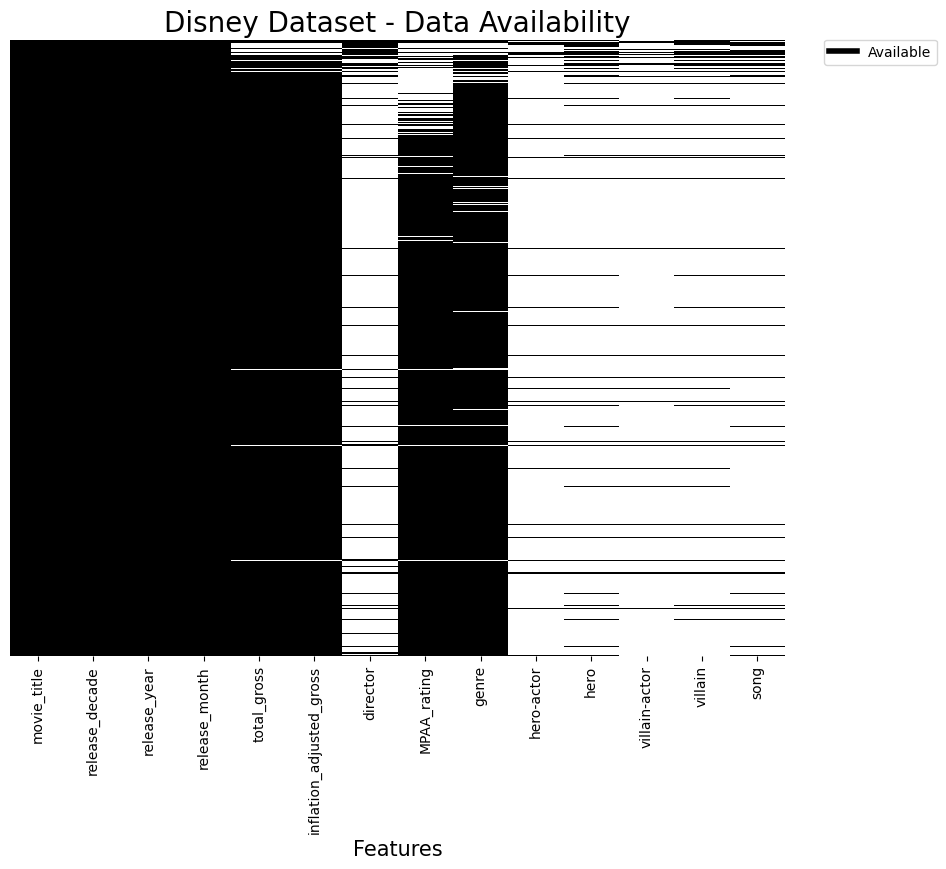

In [ ]:
# Look at Data Sparsity in Complete DataFrame
plt.figure(figsize=(10, 8))

custom_lines = [Line2D([0], [0], color="black", lw=4)]

sparsity_plot = sns.heatmap(
    complete_df.notnull(), cmap="binary", cbar=False, yticklabels=False
)

sparsity_plot.set_xlabel("Features", fontsize=15)

sparsity_plot.set_title("Disney Dataset - Data Availability", fontsize=20)

plt.legend(
    custom_lines,
    ["Available"],
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0,
)

plt.show()

Fortunately, there appears to be *~100%* data availability for `release_decade`, which is extracted from the `release_date` column.</br> 
We should be set to get accurate insights for our exploration of `release_decade` v `inflation_adjusted_gross`.

That's pretty disappointing to see that we have such high data sparsity in the following columns :
* director
* hero-actor
* hero
* villain-actor
* villain
* song

This is going to affect our ability to perform the feature discovery for `inflation_adjusted_gross`. 
Note : If we were able to identify potential features which exhibit *linear correlation* with the `inflation_adjusted_gross`, we may have been able to utilize this in building a **Regression Machine Learning** model.

# Release Decade & Inflation Adjusted Gross

Here are the top 5 movies by inflation adjusted gross.

In [ ]:
# Let's order our complete dataframe in descending order of inflation adjusted gross.
complete_df.sort_values(by="inflation_adjusted_gross", ascending=False, inplace=True)
complete_df.reset_index(drop=True, inplace=True)

display(complete_df.head(5))

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
2,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
3,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
4,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte


Through observing the top 5 highest grossing films when adjusted for inflation, we can see this data sparsity issue entailing missing features.

## Record Distribution By Decade

In [ ]:
plot_df = complete_df.query("release_decade == release_decade").assign(
    release_decade=complete_df["release_decade"].apply(lambda x: str(x) + "s")
)

In [ ]:
display_histogram(
    effective_df=plot_df,
    feature="release_decade",
    maxbins=False,  # We don't want to bin the data.
    target="count()",
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

## Highest Grossing Film of Each Decade

This dataframe is ordered in ascending order of `release_decade`, then decending order of `inflation_adjusted_gross`.

In [ ]:
complete_df.sort_values(
    by=["release_decade", "inflation_adjusted_gross"],
    ascending=[True, False],
    inplace=True,
)
complete_df.reset_index(drop=True, inplace=True)

display(complete_df.head(5))

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
2,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
3,Song of the South,1940,1946,11,65000000.0,1.078511e+09,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN
4,Dumbo,1940,1941,10,NaN,NaN,Ben Sharpsteen,NaN,NaN,None,Dumbo,NaN,Ringmaster,Baby Mine


These are the highest grossing films of each decade in ascending order of `release_decade`.


In [ ]:
# Let's get the highest grossing movie for each decade.
effective_indices = [
    i
    for decade in complete_df["release_decade"].unique()
    for i in complete_df[complete_df["release_decade"] == decade]
    .head(1)
    .index.to_list()
]

highest_grossing_decade_df = complete_df.loc[effective_indices].reset_index(drop=True)

display(highest_grossing_decade_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
2,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte
3,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
4,The Aristocats,1970,1970,4,55675257.0,2.551615e+08,Wolfgang Reitherman,G,Musical,NaN,NaN,NaN,NaN,NaN
5,3 Men and a Baby,1980,1987,11,167780960.0,3.533346e+08,NaN,PG,Comedy,NaN,NaN,NaN,NaN,NaN
6,The Lion King,1990,1994,6,422780140.0,7.616409e+08,Roger Allers,G,Adventure,Jonathan Taylor Thomas; Matthew Broderick,Simba,Jeremy Irons,Scar,Circle of Life
7,Pirates of the Caribbean: Dead Man’…,2000,2006,7,423315812.0,5.448171e+08,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN
8,Star Wars Ep. VII: The Force Awakens,2010,2015,12,936662225.0,9.366622e+08,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN


## Lowest Grossing Film of Each Decade

This dataframe is ordered in ascending order of `release_decade`, then ascending order of `inflation_adjusted_gross`.

In [ ]:
complete_df.sort_values(
    by=["release_decade", "inflation_adjusted_gross"],
    ascending=[True, True],
    inplace=True,
)
complete_df.reset_index(drop=True, inplace=True)

display(complete_df.head(5))

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Song of the South,1940,1946,11,65000000.0,1.078511e+09,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN
2,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
3,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
4,Dumbo,1940,1941,10,NaN,NaN,Ben Sharpsteen,NaN,NaN,None,Dumbo,NaN,Ringmaster,Baby Mine


In [ ]:
# Let's get the lowest grossing movie for each decade.
effective_indices = [
    i
    for decade in complete_df["release_decade"].unique()
    for i in complete_df[complete_df["release_decade"] == decade]
    .head(1)
    .index.to_list()
]

lowest_grossing_decade_df = complete_df.loc[effective_indices][
    complete_df["inflation_adjusted_gross"].notna()
]
lowest_grossing_decade_df = complete_df.loc[effective_indices].reset_index(drop=True)

display(lowest_grossing_decade_df)

C:\Users\Muntakim\AppData\Local\Temp\ipykernel_25496\3134541077.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lowest_grossing_decade_df = complete_df.loc[effective_indices][


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Song of the South,1940,1946,11,65000000.0,1.078511e+09,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN
2,Sleeping Beauty,1950,1959,1,9464608.0,2.150583e+07,Clyde Geronimi,NaN,Drama,Mary Costa,Aurora,Eleanor Audley,Maleficent,Once Upon a Dream
3,Bon Voyage!,1960,1962,5,9230769.0,1.095816e+08,NaN,Not Rated,Comedy,NaN,NaN,NaN,NaN,NaN
4,The Many Adventures of Winnie the Pooh,1970,1977,3,0.0,0.000000e+00,Wolfgang Reitherman,NaN,NaN,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh
5,Condorman,1980,1981,8,0.0,0.000000e+00,NaN,NaN,Action,NaN,NaN,NaN,NaN,NaN
6,The War at Home,1990,1996,11,34368.0,6.554300e+04,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN
7,Frank McKlusky C.I.,2000,2002,1,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Zokkomon,2010,2011,4,2815.0,2.984000e+03,NaN,PG,Adventure,NaN,NaN,NaN,NaN,NaN


We're not going to visualize the distributions of the inflation adjusted highest/lowest grossing film for each decade. These films may just be outliers in our larger dataset. 

## Inflation Adjusted Gross Distribution By Decade

In [ ]:
display_histogram(
    effective_df=complete_df,
    feature="inflation_adjusted_gross",
    target="release_decade",
    maxbins=10,
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

There appears to be a few major outliers in the data visualized above. There are tiny slivers of data for films with `inflation_adjusted_gross` > $<i>1*10^9</i>. 


### Films With Inflation Adjusted Gross Greater Than/Equal To $1*10^9.
Let's take a closer look at films which meet and exceed this threshold. 

In [ ]:
geq_1e9_df = complete_df.query(f"inflation_adjusted_gross >= 1e9")
display(geq_1e9_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Song of the South,1940,1946,11,65000000.0,1.078511e+09,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN
2,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
3,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
15,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte
24,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN


In [ ]:
display_histogram(
    effective_df=geq_1e9_df,
    feature="inflation_adjusted_gross",
    target="release_decade",
    maxbins=10,
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

These films were exclusively released between the *1930*s and *1960*s. The upper bounds of `inflation_adjusted_gross` seems to have been during this era. If Disney wishes to replicate these extremes of success, we need to understand what caused this trend, looking at macroeconomic factors (in which case, perhaps there is a lot replicability) and even internal business practices adopted during these projects.

Let's look at the rest of the data below this threshold.

In [ ]:
lt_1e9_index = [i for i in complete_df.index if i not in geq_1e9_df.index.to_list()]
lt_1e9_df = complete_df.loc[lt_1e9_index].reset_index(drop=True)

display(lt_1e9_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Dumbo,1940,1941,10,NaN,NaN,Ben Sharpsteen,NaN,NaN,None,Dumbo,NaN,Ringmaster,Baby Mine
1,Bambi,1940,1942,8,NaN,NaN,David Hand,NaN,NaN,Donnie Dunagan; Hardie Albright; Alexander Gould,Bambi,NaN,Hunter,Love Is a Song
2,Saludos Amigos,1940,1943,2,NaN,NaN,Jack Kinney,NaN,NaN,NaN,Donald Duck,NaN,NaN,Saludos Amigos\r\n
3,The Three Caballeros,1940,1945,2,NaN,NaN,Norman Ferguson,NaN,NaN,NaN,Donald Duck,NaN,NaN,NaN
4,Make Mine Music,1940,1946,4,NaN,NaN,Jack Kinney,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,Avengers: Age of Ultron,2010,2015,5,459005868.0,459005868.0,NaN,PG-13,Action,NaN,NaN,NaN,NaN,NaN
583,Finding Dory,2010,2016,6,486295561.0,486295561.0,NaN,PG,Adventure,NaN,NaN,NaN,NaN,NaN
584,Rogue One: A Star Wars Story,2010,2016,12,529483936.0,529483936.0,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN
585,The Avengers,2010,2012,5,623279547.0,660081224.0,NaN,PG-13,Action,NaN,NaN,NaN,NaN,NaN


In [ ]:
display_histogram(
    effective_df=lt_1e9_df,
    feature="inflation_adjusted_gross",
    target="release_decade",
    maxbins=10,
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Similarly, we may want to exclude films with `inflation_adjusted_gross` >= $<i>5*10^8</i>.

### Films With Inflation Adjusted Gross Greater Than/Equal To $5*10^8.
Let's take a closer look at films which meet and exceed this threshold.

In [ ]:
geq_5e8_df = complete_df.query(f"inflation_adjusted_gross >= 5e8")
display(geq_5e8_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
1,Song of the South,1940,1946,11,65000000.0,1.078511e+09,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN
2,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
3,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
13,"20,000 Leagues Under the Sea",1950,1954,12,28200000.0,5.282800e+08,NaN,NaN,Adventure,NaN,NaN,NaN,NaN,NaN
14,Cinderella,1950,1950,2,85000000.0,9.206087e+08,Wilfred Jackson,G,Drama,Ilene Woods,Cinderella,Eleanor Audley; Susanne Blakeslee,Lady Tremaine,Bibbidi-Bobbidi-Boo
15,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte
23,The Jungle Book,1960,1967,10,186185956.0,8.785427e+08,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
24,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
331,The Lion King,1990,1994,6,422780140.0,7.616409e+08,Roger Allers,G,Adventure,Jonathan Taylor Thomas; Matthew Broderick,Simba,Jeremy Irons,Scar,Circle of Life


In [ ]:
display_histogram(
    effective_df=geq_5e8_df,
    feature="inflation_adjusted_gross",
    target="release_decade",
    maxbins=10,
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

This is really interesting. We now have more recent films included in this data as the *1990*s, *2000*s, and *2010*s are present in the data which meets this threshold. Let's look at the data visualized here which was released past the *1960*s.

#### Films Released Past 1960s Which Meet Threshold

In [ ]:
geq5e8_1960s_df = geq_5e8_df.query(f"release_decade > 1960")
display_histogram(
    geq5e8_1960s_df,
    feature="inflation_adjusted_gross",
    target="release_decade",
    maxbins=10,
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Observations 
* There are *2* films from the *2000*s which have grossed between $<i>5.0-5.5*10^8</i> when adjusted for inflation.  
* There are *3* films from the *2010*s which have grossed >= $<i>5*10^8</i> when adjusted from inflation. 
    * One of these films from the *2010*s have grossed between $<i>9.0-9.5*10^8</i> which is highly interesting.
* There is *1* film from the *1990*s which has grossed between $<i>7.5-8.0*10^8</i>. This seems to be a sole project from this decade which has passed this threshold, which is interesting as well.

In [ ]:
geq5e8_1960s_df.sort_values(
    by="inflation_adjusted_gross", ascending=False, inplace=True
)
geq5e8_1960s_df.reset_index(drop=True, inplace=True)

display(geq5e8_1960s_df)

C:\Users\Muntakim\AppData\Local\Temp\ipykernel_25496\3979521889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geq5e8_1960s_df.sort_values(


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Star Wars Ep. VII: The Force Awakens,2010,2015,12,936662225.0,936662225.0,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN
1,The Lion King,1990,1994,6,422780140.0,761640898.0,Roger Allers,G,Adventure,Jonathan Taylor Thomas; Matthew Broderick,Simba,Jeremy Irons,Scar,Circle of Life
2,The Avengers,2010,2012,5,623279547.0,660081224.0,NaN,PG-13,Action,NaN,NaN,NaN,NaN,NaN
3,Pirates of the Caribbean: Dead Man’…,2000,2006,7,423315812.0,544817142.0,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN
4,Rogue One: A Star Wars Story,2010,2016,12,529483936.0,529483936.0,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN
5,Finding Nemo,2000,2003,5,380529370.0,518148559.0,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN


This is pretty interesting. Most of these are franchise films.</br></br>
The outliers are :
    <li>*Finding Nemo* was a **Pixar** film prior to the **Disney** acquisition.</li>
    <li>*The Lion King* is a standalone animation.</li>

#### Star Wars Films
What made *Star Wars Ep. VII: The Force Awakens* such a major success in this time period?</br>
Let's look at the other films in the **Star Wars** franchise. 

In [ ]:
star_wars_df = complete_df[
    complete_df["movie_title"].str.lower().str.contains("star")
    & complete_df["movie_title"].str.lower().str.contains("wars")
]
display(star_wars_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
590,Rogue One: A Star Wars Story,2010,2016,12,529483936.0,529483936.0,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN
592,Star Wars Ep. VII: The Force Awakens,2010,2015,12,936662225.0,936662225.0,NaN,PG-13,Adventure,NaN,NaN,NaN,NaN,NaN


We only have data for *2* of the films in the **Star Wars** franchise. This is an implicit data sparsity issue as there are *10* films in the franchise.

This dataset should be updated to reflect the box office history for this franchise prior to the **Disney** acquisition of **Lucasfilm** as well as to reflect the box office history for the *Star Wars* films released after the acquisition.

### Films With Inflation Adjusted Gross Less Than $5*10^8.

In [ ]:
lt_5e8_index = [i for i in complete_df.index if i not in geq_5e8_df.index.to_list()]
lt_5e8_df = complete_df.loc[lt_5e8_index].reset_index(drop=True)

display(lt_5e8_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Dumbo,1940,1941,10,NaN,NaN,Ben Sharpsteen,NaN,NaN,None,Dumbo,NaN,Ringmaster,Baby Mine
1,Bambi,1940,1942,8,NaN,NaN,David Hand,NaN,NaN,Donnie Dunagan; Hardie Albright; Alexander Gould,Bambi,NaN,Hunter,Love Is a Song
2,Saludos Amigos,1940,1943,2,NaN,NaN,Jack Kinney,NaN,NaN,NaN,Donald Duck,NaN,NaN,Saludos Amigos\r\n
3,The Three Caballeros,1940,1945,2,NaN,NaN,Norman Ferguson,NaN,NaN,NaN,Donald Duck,NaN,NaN,NaN
4,Make Mine Music,1940,1946,4,NaN,NaN,Jack Kinney,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,Frozen,2010,2013,11,400738009.0,414997174.0,Chris Buck,PG,Adventure,Idina Menzel,Elsa,Santino Fontana,Prince Hans,Let It Go\r\n
574,Iron Man 3,2010,2013,5,408992272.0,424084233.0,NaN,PG-13,Action,NaN,NaN,NaN,NaN,NaN
575,Toy Story 3,2010,2010,6,415004880.0,443408255.0,NaN,G,Adventure,NaN,NaN,NaN,NaN,NaN
576,Avengers: Age of Ultron,2010,2015,5,459005868.0,459005868.0,NaN,PG-13,Action,NaN,NaN,NaN,NaN,NaN


In [ ]:
display_histogram(
    effective_df=lt_5e8_df,
    feature="inflation_adjusted_gross",
    target="release_decade",
    maxbins=10,
)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

It's appears that there is a **exponential decay**-like relationship between `inflation_adjusted_gross` and the `record count`. **Disney**'s historical track record tends towards outputting films with relatively lower `inflation_adjusted_gross` values.

This seems to be the case across the remaining decades here, with a few exceptions. The <i>2010</i>s seem interesting. There are a few films which have `inflation_adjusted_gross` between $<i>2.0-2.5*10^8</i>

# Directors and Actors Exploration

In [ ]:
exploration_df = complete_df[
    complete_df["inflation_adjusted_gross"].notna()
].sort_values(by="inflation_adjusted_gross", ascending=False)

## Directors & Inflation Adjusted Gross

In [ ]:
display(exploration_df[exploration_df["director"].notna()].head())

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come
3,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
2,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
24,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
15,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte


In [ ]:
display(exploration_df[exploration_df["director"].notna()].tail())

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
71,The Great Mouse Detective,1980,1986,7,23605534.0,53637367.0,Ron Clements,NaN,Adventure,NaN,Basil,Vincent Price,Professor Ratigan,The World's Greatest Criminal Mind
69,The Black Cauldron,1980,1985,7,21288692.0,50553142.0,Ted Berman,NaN,Adventure,Grant Bardsley,Taran,NaN,Horned King,NaN
527,Winnie the Pooh,2010,2011,7,26692846.0,28375869.0,Stephen J. Anderson,G,Adventure,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh\r\n
12,Sleeping Beauty,1950,1959,1,9464608.0,21505832.0,Clyde Geronimi,NaN,Drama,Mary Costa,Aurora,Eleanor Audley,Maleficent,Once Upon a Dream
26,The Many Adventures of Winnie the Pooh,1970,1977,3,0.0,0.0,Wolfgang Reitherman,NaN,NaN,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh


In [ ]:
director_plots = display_concat_histograms(
    effective_df=exploration_df,
    feature="inflation_adjusted_gross",
    target="director",
    category_title="Grossing Films",
    maxbins=5,
    record_count=5,
)

display(director_plots)

Lowest Grossing Films:


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,The Many Adventures of Winnie the Pooh,1970,1977,3,0.0,0.0,Wolfgang Reitherman,NaN,NaN,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh
1,Sleeping Beauty,1950,1959,1,9464608.0,21505832.0,Clyde Geronimi,NaN,Drama,Mary Costa,Aurora,Eleanor Audley,Maleficent,Once Upon a Dream
2,Winnie the Pooh,2010,2011,7,26692846.0,28375869.0,Stephen J. Anderson,G,Adventure,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh\r\n
3,The Black Cauldron,1980,1985,7,21288692.0,50553142.0,Ted Berman,NaN,Adventure,Grant Bardsley,Taran,NaN,Horned King,NaN
4,The Great Mouse Detective,1980,1986,7,23605534.0,53637367.0,Ron Clements,NaN,Adventure,NaN,Basil,Vincent Price,Professor Ratigan,The World's Greatest Criminal Mind




Highest Grossing Films:


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
42,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte
43,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
44,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
45,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
46,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come


c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.ConcatChart(...)

From our data, we are able to look at *5* of the `lowest grossing films` and *5* of the `highest grossing films` out of the *films with non-null director information*. 

We've accounted for duplicates and filtered them from the `Highest Grossing Films : Distribution`. The decision was made to classify these with the `Lowest Grossing Films : Distribution` as we can't really rely on these being projects we'd like to replicate in upcoming initiatives.

Starting with Highest Grossing Films :</br>
<ul>
    <li>
        <i>David Hand</i> directed the highest grossing film when adjusted for inflation, which happens to be the highest grossing film in the entire dataset (i.e. <i>Snow White</i>).
    </li> 
</ul>

Looking at Lowest Grossing Films :</br>
<ul>
    <li>
        <i>Wolfgang Reitherman</i> directed the lowest grossing film when adjusted for inflation and another film which was included in the plot for the highest grossing films.
        <ul>
            <li>
                Perhaps his work isn't completely replicable. We might have to look into when his projects have been more/less successful financially.
            </li>
        </ul>
    </li>
</ul>

### Directors Ranked By Film Count
Let's look at the directors who have directed the most films in the dataset.

In [ ]:
# Get the Total Number of Films for Each Director.
directors_df = ranked_df(complete_df, "director")

display(directors_df)

,director,number_of_films
0,Wolfgang Reitherman,8
1,Ron Clements,8
2,Clyde Geronimi,4
3,Jack Kinney,4
4,Gary Trousdale,3
5,Mark Dindal,2
6,Hamilton Luske,2
7,Wilfred Jackson,2
8,Stephen J. Anderson,2
9,Robert Walker,2


### Wolfgang Reitherman's Films

That's interesting how *Wolfgang Reitherman* has directed the highest `number_of_films` given our prior observation of his films' ability to generate box office revenu. Let's query these and visualize them.

In [ ]:
wolfgang_df = (
    complete_df.query(f'director == "Wolfgang Reitherman"')
    .sort_values(by="inflation_adjusted_gross", ascending=True)
    .reset_index(drop=True)
)
display(wolfgang_df)

,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,The Many Adventures of Winnie the Pooh,1970,1977,3,0.0,0.000000e+00,Wolfgang Reitherman,NaN,NaN,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh
1,The Sword in the Stone,1960,1963,12,22182353.0,1.538708e+08,Wolfgang Reitherman,NaN,Adventure,NaN,Arthur,Martha Wentworth,Madam Mim,Higitus Figitus\r\n
2,The Rescuers,1970,1977,6,48775599.0,1.597439e+08,Wolfgang Reitherman,NaN,Adventure,NaN,Bernard and Miss Bianca,Geraldine Page,Madame Medusa,The Journey
3,The Aristocats,1970,1970,4,55675257.0,2.551615e+08,Wolfgang Reitherman,G,Musical,NaN,NaN,NaN,NaN,NaN
4,The Jungle Book,1960,1967,10,186185956.0,8.785427e+08,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
5,101 Dalmatians,1960,1961,1,289189294.0,1.621600e+09,Wolfgang Reitherman,G,Comedy,NaN,NaN,NaN,NaN,NaN
6,The Aristocats,1970,1970,12,NaN,NaN,Wolfgang Reitherman,NaN,NaN,NaN,Thomas and Duchess,NaN,Edgar Balthazar,Ev'rybody Wants to Be a Cat
7,Robin Hood,1970,1973,11,NaN,NaN,Wolfgang Reitherman,NaN,NaN,Brian Bedford,Robin Hood,Peter Ustinov,Prince John,Oo De Lally


In [ ]:
wolfgang_plots = display_histogram(
    effective_df=wolfgang_df,
    feature="inflation_adjusted_gross",
    target="count()",
    plot_title="Wolfgang Reitherman Film & Box Office Performance",
    maxbins=5,
)

display(wolfgang_plots)

c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

From this histogram, we can see that *Wolfgang Reitherman* has directed mostly films which have grossed between $<i>0.0-5.0*10^8</i> when adjusted for inflation.

He has directed *2* films which have grossed between $<i>5.0-20.0*10^8</i> when adjusted for inflation, which are *The Jungle Book* and *101 Dalmatians*. These are the *2* films which we saw were rereleased during our cleaning procedure.

#### Rereleased Films

This provides merit to **Disney**'s practice of rereleasing their major successes. Anecdotally, **Avatar**, **Spiderman : No Way Home** and a few more films have been rereleased in the past few years. These films are some of the highest grossing films of all time prior to being adjusted for inflation.

**Avatar** was a part of the **Fox** acquisition. This film itself is the *2*nd highest grossing film of all time when adjusted for inflation.  

## Heroes & Inflation Adjusted Gross

In [ ]:
hero_plots = display_concat_histograms(
    effective_df=exploration_df,
    feature="inflation_adjusted_gross",
    target="hero",
    category_title="Grossing Films",
    maxbins=5,
    record_count=5,
)

display(hero_plots)

Lowest Grossing Films:


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,The Many Adventures of Winnie the Pooh,1970,1977,3,0.0,0.0,Wolfgang Reitherman,NaN,NaN,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh
1,Sleeping Beauty,1950,1959,1,9464608.0,21505832.0,Clyde Geronimi,NaN,Drama,Mary Costa,Aurora,Eleanor Audley,Maleficent,Once Upon a Dream
2,Winnie the Pooh,2010,2011,7,26692846.0,28375869.0,Stephen J. Anderson,G,Adventure,NaN,Winnie the Pooh,NaN,NaN,Winnie the Pooh\r\n
3,The Black Cauldron,1980,1985,7,21288692.0,50553142.0,Ted Berman,NaN,Adventure,Grant Bardsley,Taran,NaN,Horned King,NaN
4,The Great Mouse Detective,1980,1986,7,23605534.0,53637367.0,Ron Clements,NaN,Adventure,NaN,Basil,Vincent Price,Professor Ratigan,The World's Greatest Criminal Mind




Highest Grossing Films:


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
34,The Jungle Book,1960,1967,10,186185956.0,8.785427e+08,Wolfgang Reitherman,Not Rated,Musical,Bruce Reitherman,Mowgli,NaN,Kaa and Shere Khan,The Bare Necessities\r\n
35,Cinderella,1950,1950,2,85000000.0,9.206087e+08,Wilfred Jackson,G,Drama,Ilene Woods,Cinderella,Eleanor Audley; Susanne Blakeslee,Lady Tremaine,Bibbidi-Bobbidi-Boo
36,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte
37,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
38,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come


c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.ConcatChart(...)

Starting with Highest Grossing Films :</br>
<ul>
    <li>
        <i>Snow White</i> is the heroine of the highest grossing film when adjusted for inflation, which happens to be the highest grossing film in the entire dataset (i.e. <i>Snow White</i>).
    </li>
    <li>
        <i>Pinocchio</i> is the runner up for the hero in the highest grossing film when adjusted for inflation. This film was released in the <i>1940</i>s, which makes sense when considering our observation that the films released before and during the <i>1960</i>s had the highest inflation adjusted gross.
    </li>  
</ul>

Looking at Lowest Grossing Films :</br>
<ul>
    <li>
        <i>Winnie the Pooh</i> is the hero in the lowest grossing film when adjusted for inflation and another film in the group of lowest grossing films as well. 
        <ul>
            <li>
                Before we classify this character as a serial offender, we should recall that there is data sparsity and we need more data to make an informed decision whether or not to exclude him from upcoming projects.
            </li>
        </ul>
    </li>
    <li>
        Note : I'm going to include an anecdotal observation from personal experience. I cannot identify the <i>Basit</i> and <i>Taran</i> characters in the plot for the lowest grossing films. These characters may perhaps not be well known by the general public. We might want to do some research to see whether the larger <b>Disney</b> audience can identify these characters and what their perspective on their respective films are.
    </li>
</ul>

### Heroes Ranked By Film Count
Let's look at the heroes who have appeared in the most films.

In [ ]:
# Get the Total Number of Films for Each Hero.
heroes_df = ranked_df(complete_df, "hero")

display(heroes_df)

,hero,number_of_films
0,Winnie the Pooh,2
1,Donald Duck,2
2,Bernard and Miss Bianca,2
3,Moana,1
4,Mowgli,1
5,Mr. Toad and Ichabod Crane,1
6,Mulan,1
7,Oliver,1
8,Peter Pan,1
9,Pinocchio,1


There isn't a `hero` who has appeared in a relatively higher `number_of_films` than the others. This makes it difficult to identify heroes which have consistently amounted to box office success.

## Villains & Inflation Adjusted Gross

In [ ]:
villain_plots = display_concat_histograms(
    effective_df=exploration_df,
    feature="inflation_adjusted_gross",
    target="villain",
    category_title="Grossing Films",
    maxbins=5,
    record_count=5,
)

display(villain_plots)

Lowest Grossing Films:


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
0,Sleeping Beauty,1950,1959,1,9464608.0,21505832.0,Clyde Geronimi,NaN,Drama,Mary Costa,Aurora,Eleanor Audley,Maleficent,Once Upon a Dream
1,The Black Cauldron,1980,1985,7,21288692.0,50553142.0,Ted Berman,NaN,Adventure,Grant Bardsley,Taran,NaN,Horned King,NaN
2,The Great Mouse Detective,1980,1986,7,23605534.0,53637367.0,Ron Clements,NaN,Adventure,NaN,Basil,Vincent Price,Professor Ratigan,The World's Greatest Criminal Mind
3,Treasure Planet,2000,2002,11,38120554.0,55189145.0,Ron Clements,PG,Adventure,Joseph Gordon-Levitt,Jim Hawkins,Brian Murray,John Silver,I'm Still Here\r\n
4,The Rescuers Down Under,1990,1990,11,27931461.0,55796728.0,Mike Gabriel,G,Adventure,NaN,Bernard and Miss Bianca,George C. Scott,Percival C. McLeach,\r\n




Highest Grossing Films:


,movie_title,release_decade,release_year,release_month,total_gross,inflation_adjusted_gross,director,MPAA_rating,genre,hero-actor,hero,villain-actor,villain,song
30,Cinderella,1950,1950,2,85000000.0,9.206087e+08,Wilfred Jackson,G,Drama,Ilene Woods,Cinderella,Eleanor Audley; Susanne Blakeslee,Lady Tremaine,Bibbidi-Bobbidi-Boo
31,Lady and the Tramp,1950,1955,6,93600000.0,1.236036e+09,Hamilton Luske,G,Drama,NaN,Lady and Tramp,NaN,Si and Am,Bella Notte
32,Fantasia,1940,1940,11,83320000.0,2.187091e+09,full credits,G,Musical,NaN,NaN,Corey Burton,Chernabog,NaN
33,Pinocchio,1940,1940,2,84300000.0,2.188229e+09,Ben Sharpsteen,G,Adventure,Dickie Jones,Pinocchio,Charles Judels,Stromboli,When You Wish upon a Star
34,Snow White and the Seven Dwarfs,1930,1937,12,184925485.0,5.228953e+09,David Hand,G,Musical,Adriana Caselotti,Snow White,NaN,Evil Queen,Some Day My Prince Will Come


c:\Users\Muntakim\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.ConcatChart(...)

The *3* villains who I recognize from this list immediately are :
<ul>
    <li>
        <i>Maleficient</i> from <i>Sleeping Beauty</i>
    </li>
    <li>
        <i>The Evil Queen</i> from <i>Snow White</i>
    </li>
    <li>
        <i>Lady Tremaine</i> from <i>Cinderella</i>
    </li>
</ul>

The results here surprised me. I expected to see <i>Maleficient</i> in the `Highest Grossing Films : Distribution` plot. This is a character who has multiple spin-offs and is a part of the <i>Maleficient</i> franchise. She is described to be "one of the most sinister **Disney** Villains" and is deemed to be an iconic character. It surprised me that the *Sleeping Beauty* film was the lowest grossing film in the dataset when adjusted for inflation. 

### Villains Ranked By Film Count
Let's look at the villains who have appeared in the most films.

In [ ]:
# Get the Total Number of Films for Each Hero.
villains_df = ranked_df(complete_df, "villain")

display(villains_df)

,villain,number_of_films
0,Alameda Slim,1
1,Professor Ratigan,1
2,Madam Mim,1
3,Madame Medusa,1
4,Maleficent,1
5,Mother Gothel,1
6,Mr. Winkie and The Headless Horseman,1
7,Percival C. McLeach,1
8,Prince Hans,1
9,Prince John,1


No `villain` has appeared in more than *1* film according to our dataset. I know this to be false as <i>Maleficient</i> has a spin-off film and is a part of the <i>Maleficient</i> franchise. We cannot perform the investigation of repeated appearances of villains in films as we don't have the data to do so.

# Discussion

From this investigation, we were able to observe **Disney** films released through the decades. We were able to identify the most successful films and the least successful films over the years. It's evident that the **Golden Age** and **Silver Age** of **Disney** films (*1930-1960*s) were the most successful. This seems to be a "magical" period in **Disney**'s history. Even though the **Renaissance Era** (*1980-1990*s) was a period of success for **Disney**, it was not as successful as the **Golden Age** and **Silver Age**. 

## Assumptions

This aligns with what I expected to find as some of the highest inflation adjusted grossing films of all times are from this period (e.g. *Gone With the Wind*, *The Sound of Music*, *The Ten Commandments*). I didn't expect to find *Sleeping Beauty* being a relatively lower grossing film when adjusted for inflation. I was under the assumption that this is a **Disney** classic and its success sparked the creation of the *Maleficient* franchise.

## Future Success

Based on our exploration, **Disney**'s best bets are to try to replicate the success of the **Golden Age** and **Silver Age**, however this seems rather complex. An easier route is to replicate more recent successes such as through standalone animations (*The Lion King*) and long-running franchises, especially those which were part of major acquisitions (**Marvel**, **Star Wars**, **Pixar**, **Fox**). We are missing data for entries in these franchises which makes it difficult to confirm the strong box office track record of these franchises. However, the *Avatar*, *Avengers*, *Star Wars* films are some of the highest inflation adjusted grossing films of all time.

**Disney** is in a good place to continue to replicate their success. They have a strong track record of success and have a large portfolio of franchises which have been successful. They have a strong pipeline of upcoming films which are expected to be successful.

## Further Exploration

We were able to identify the *directors*, *heroes*, and *villains* who have been most successful in generating box office revenue. However, this latter exploration was limited by data sparsity. We did not gain conclusive evidence behind features which consistently contribute to success here. Ideally if we had more data, we would be able to identify these features and replicate them in upcoming projects.

### Questions

I would like to conduct the following investigation based on `director`-`actor` projects and **Inflation Adjusted Gross** :

* Which top 5 actors-directors worked together most frequently?
    * What was the average inflation adjusted gross of their movies?

I would also like to have data on which production house each film falls under (e.g. **Pixar**, **Marvel**, **20th Century Studios**). This would allow us to investigate the success of each production house and which production houses we should be investing in.

## Citations

These links provide the theory and basis for the *ML* exploration in this notebook.

* [IBM - What is Machine Learning?](https://www.ibm.com/topics/machine-learning)